# Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2

# Load Data

In [36]:
xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-P001/ses-S001/mic/sub-P001_ses-S001_task-MicTest_run-001_mic.xdf"
#xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-P666/ses-S001/mobi/sub-P666_ses-S001_task-Story_run-001_mobi.xdf"
#xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-Pbryan/ses-S001/mic/sub-Pbryan_ses-S001_task-MicTest_run-001_mic.xdf"
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

# Stimulus

## Stimulus Trigger Duration - Story Listening

In [4]:
streams_collected.index('Audio')

1

In [5]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_ExperimentStart',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_ExperimentEnd',
}

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_ExperimentStart,1.814282e+06,0.000000e+00
1,1724088943,psychopy_time_stamp,1.814282e+06,1.460011e-08
2,10,Onset_RestingState,1.814286e+06,3.914211e-03
3,1724088947,psychopy_time_stamp,1.814286e+06,3.914222e-03
4,11,Offset_RestingState,1.814586e+06,3.039237e-01
5,1724089247,psychopy_time_stamp,1.814586e+06,3.039237e-01
6,500,Onset_StoryListening,1.814586e+06,3.039238e-01
7,1724089247,psychopy_time_stamp,1.814586e+06,3.039238e-01
8,100,Onset_10second_rest,1.814614e+06,3.312225e-01
9,1724089274,psychopy_time_stamp,1.814614e+06,3.312225e-01


In [6]:
def get_event_data(event, df, stim_df=stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]




In [16]:
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']
evs

,trigger,event,lsl_time_stamp,time
0,200,Onset_ExperimentStart,1.814282e+06,0.000000
2,10,Onset_RestingState,1.814286e+06,0.003914
4,11,Offset_RestingState,1.814586e+06,0.303924
6,500,Onset_StoryListening,1.814586e+06,0.303924
8,100,Onset_10second_rest,1.814614e+06,0.331222
10,101,Offset_10second_rest,1.814624e+06,0.341223
12,60,Onset_Tornado,1.814624e+06,0.341315
14,61,Offset_Tornado,1.814787e+06,0.504559
16,300,Onset_subjectInput,1.814791e+06,0.508302
18,301,Offset_subjectInput,1.814792e+06,0.509823


In [46]:
def get_secs_between_triggers(trigger1, trigger2):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

# Get a list of the story names using the events dict
#story_names = [x.split('_')[1] for x in list(events.values())[2:][::2]]
#story_names

story_onsets = [x for x in list(events.keys()) if "Onset" in x] #every other trigger is the offset
story_onsets

TypeError: argument of type 'int' is not iterable

In [8]:
files= [
    "../audio_files/audio_files/After_Searching_I_Found_and_Met_My_Birth_Mother.wav",
    "../audio_files/audio_files/Camp_Lose_A_Friend.wav",
    "../audio_files/audio_files/Frog_Dissection_Disaster.wav",
    "../audio_files/audio_files/I_Decided_To_Be_Myself_And_Won_A_Dance_Contest.wav",
    "../audio_files/audio_files/I_Fully_Embarrassed_Myself_In_Zoom_Class1.wav",
    "../audio_files/audio_files/Left_Home_Alone_in_a_Tornado.wav",
    "../audio_files/audio_files/The_Birthday_Party_Prank.wav",
    "../audio_files/audio_files/My_Dad_Saw_Me_Wearing_Glitter_At_School.wav"
]


durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x) for x in story_onsets],
    'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in files] #duration of audio file is number of frames divided by the frame rate.
})

durations['difference(sec)'] = durations['audiofile_duration'] - durations['lsl_duration']
durations

NameError: name 'story_onsets' is not defined

## Stimulus Triggers - Social Script

In [3]:
stim_dat = data[4]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)

events = {100: 'Conversation_start', 
          101: 'Conversation_end'}

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 4 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 4, 'event'] = 'psychopy_time_stamp'
stim_df['time'] = stim_dat['time_stamps'] #- stim_dat['time_stamps'][0]

conversation_onset_stim = stim_df.loc[stim_df.event == 'Conversation_start', 'time'].values[0]
conversation_offset_stim = stim_df.loc[stim_df.event == 'Conversation_end', 'time'].values[0]
stim_df


,trigger,event,time
0,100,Conversation_start,341598.449366
1,1722616294,psychopy_time_stamp,341598.449377
2,101,Conversation_end,341899.951128
3,1722616595,psychopy_time_stamp,341899.951139


# Physio

In [22]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000

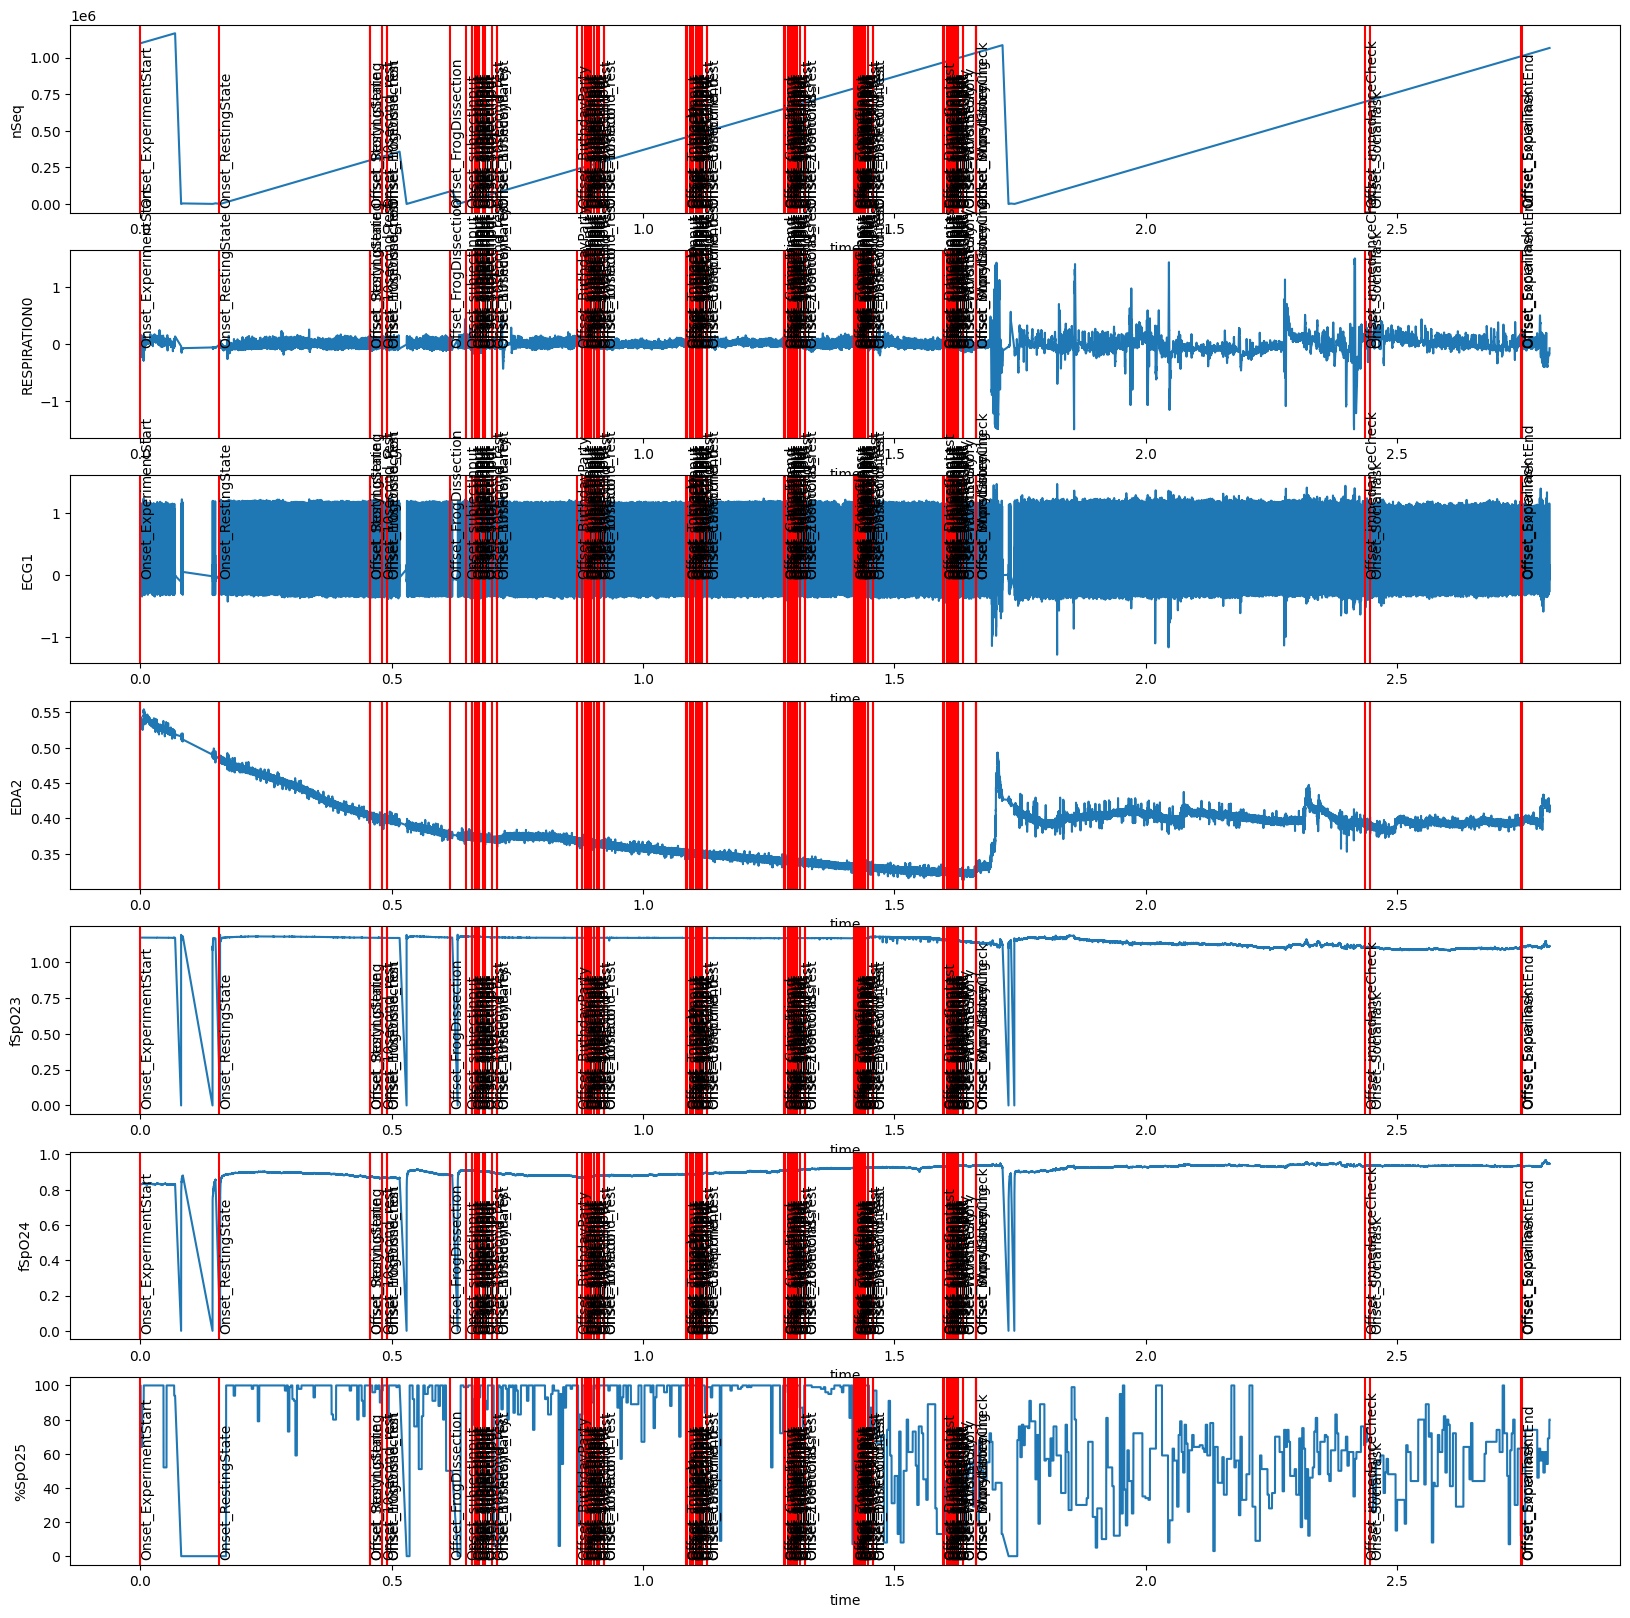

In [9]:
    
'''
# Plot every column in one plot
plt.figure(figsize=(20,10))
for col in ps_df.columns:
    plt.plot(ps_df['time'], ps_df[col])
plt.show()
'''
#f, ax = plt.subplots(figsize=(20,20), nrows=4, ncols=1)
f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])
    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    #plt.title(col)
    #plt.show()

In [1]:
physio_resting_state = get_event_data('CampFriend', ps_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state, x='time', y=col, ax=ax[i])

NameError: name 'get_event_data' is not defined

# Linking Microphone Data to Video Data

In [30]:
mic_data = data[streams_collected.index('Audio')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000
mic_df.head()

ValueError: 'Audio' is not in list

In [9]:
#conversation_onset_stim = stim_df.loc[stim_df.event == 'Onset_SocialTask', 'time'].values[0]
#conversation_offset_stim = stim_df.loc[stim_df.event == 'Offset_SocialTask', 'time'].values[0]
#
# convo = mic_df.loc[(mic_df['time'] > conversation_onset_stim ) & (mic_df['time'] < conversation_offset_stim), 'int_array'].values
convo = get_event_data('Tornado', mic_df)
convo


,int_array,bytestring,lsl_time_stamp,time
913342,24,b'\x18\x00\x00\x00',1.814624e+06,0.020711
913343,22,b'\x16\x00\x00\x00',1.814624e+06,0.020711
913344,20,b'\x14\x00\x00\x00',1.814624e+06,0.020711
913345,17,b'\x11\x00\x00\x00',1.814624e+06,0.020711
913346,17,b'\x11\x00\x00\x00',1.814624e+06,0.020711
...,...,...,...,...
8112372,-31,b'\xe1\xff\xff\xff',1.814787e+06,0.183955
8112373,-30,b'\xe2\xff\xff\xff',1.814787e+06,0.183955
8112374,-32,b'\xe0\xff\xff\xff',1.814787e+06,0.183955
8112375,-31,b'\xe1\xff\xff\xff',1.814787e+06,0.183955


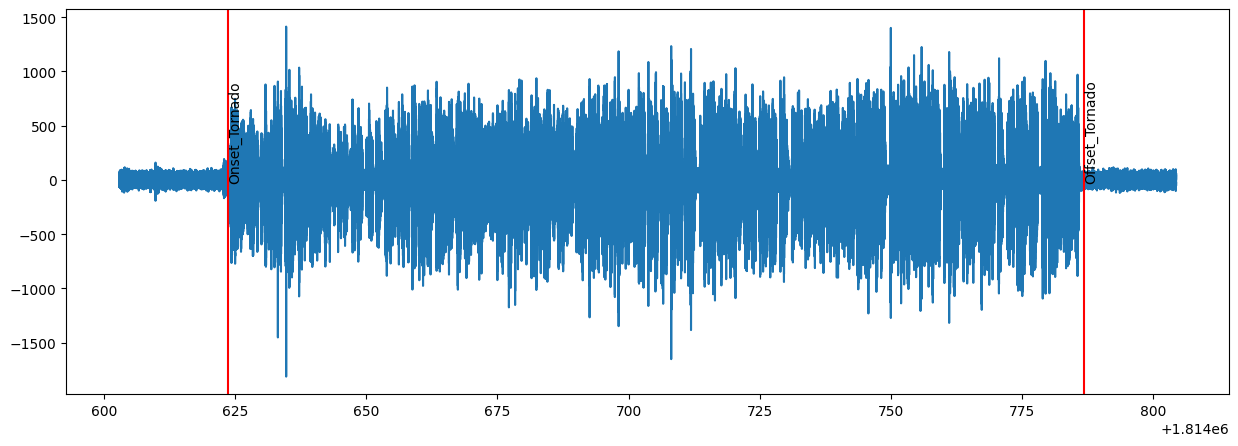

In [35]:
f, ax = plt.subplots(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in evs.loc[evs.event.str.contains('Tornado')].iterrows():
    ax.axvline(event[1]['lsl_time_stamp'], color='r')
    ax.text(event[1]['lsl_time_stamp'], 0, event[1]['event'], rotation=90)
        

In [13]:
sd.play(convo.int_array.values)

# Video Data
Now lets open the video frames

In [26]:
# Identify the frames we're interested in
cam_data = data[streams_collected.index('WebcamStream')]

#cam_df = pd.DataFrame(cam['time_series'], columns=['frame'])
#cam_df['lsl_timestamps'] = cam['time_stamps']
#cam_df['time'] = cam_df['lsl_timestamps'] - cam_df['lsl_timestamps'][0]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]


cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})



cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp #- cam_df.lsl_time_stamp[0]
cam_df['time'] = (cam_df.lsl_time_stamp - cam_df.lsl_time_stamp[0])/1000

In [27]:
#vid_convo = cam_df.loc[(cam_df['lsl_time_sec'] > conversation_onset_stim ) & (cam_df['lsl_time_sec'] < conversation_offset_stim)]
vid_convo = get_event_data('SocialTask', cam_df)
vid_convo_frames = vid_convo['frame_num'].values

A goal here is to identify timestamps in the microphone data and their corresponding frames in the video data

In [64]:
sd.play(convo.int_array.values, 44100)


In [29]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        cv2.imshow('Frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        else:
            continue
    else:
        break


: 

In [28]:
# Use cv2 to read the video file and play the frames
cap = cv2.VideoCapture('C:/Users/Admin/Documents/code/MOBI2024/CUNY_FACIAL/video_files/2222_CUNY_Face_Full_Protocol.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# play the video
while(cap.isOpened()):
    sd.play(convo.int_array.values, 44100)
    ret, frame = cap.read()
    if ret == True:
        if cap.get(1) in vid_convo_frames:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            continue
    else:
        break


KeyboardInterrupt: 

# Eye Tracking

In [38]:
ET = data[4]
et_dat = ET['time_series']
# Get the column names
column_labels = [ET['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(ET['info']['desc'][0]['channels'][0]['channel']))]

et_df = pd.DataFrame(data=et_dat, columns=column_labels)
et_df['time'] = (ET['time_stamps'] - ET['time_stamps'][0])/1000
et_df.head()

,device_time_stamp,left_gaze_origin_validity,right_gaze_origin_validity,left_gaze_origin_in_user_coordinate_system_0,left_gaze_origin_in_user_coordinate_system_1,left_gaze_origin_in_user_coordinate_system_2,right_gaze_origin_in_user_coordinate_system_0,right_gaze_origin_in_user_coordinate_system_1,right_gaze_origin_in_user_coordinate_system_2,left_gaze_origin_in_trackbox_coordinate_system_0,...,right_gaze_point_in_user_coordinate_system_2,left_gaze_point_on_display_area_0,left_gaze_point_on_display_area_1,right_gaze_point_on_display_area_0,right_gaze_point_on_display_area_1,left_pupil_validity,right_pupil_validity,left_pupil_diameter,right_pupil_diameter,time
0,7.285822e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000
1,7.285831e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000008
2,7.285839e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000017
3,7.285848e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000025
4,7.285856e+09,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000033


In [40]:
et_df.time.describe()

count    93861.000000
mean         0.391096
std          0.225803
min          0.000000
25%          0.195548
50%          0.391096
75%          0.586645
max          0.782193
Name: time, dtype: float64

In [41]:
ps_df.time.describe()

count    2.677696e+06
mean     1.446653e+03
std      7.912824e+02
min      0.000000e+00
25%      7.761076e+02
50%      1.445182e+03
75%      2.134669e+03
max      2.803854e+03
Name: time, dtype: float64

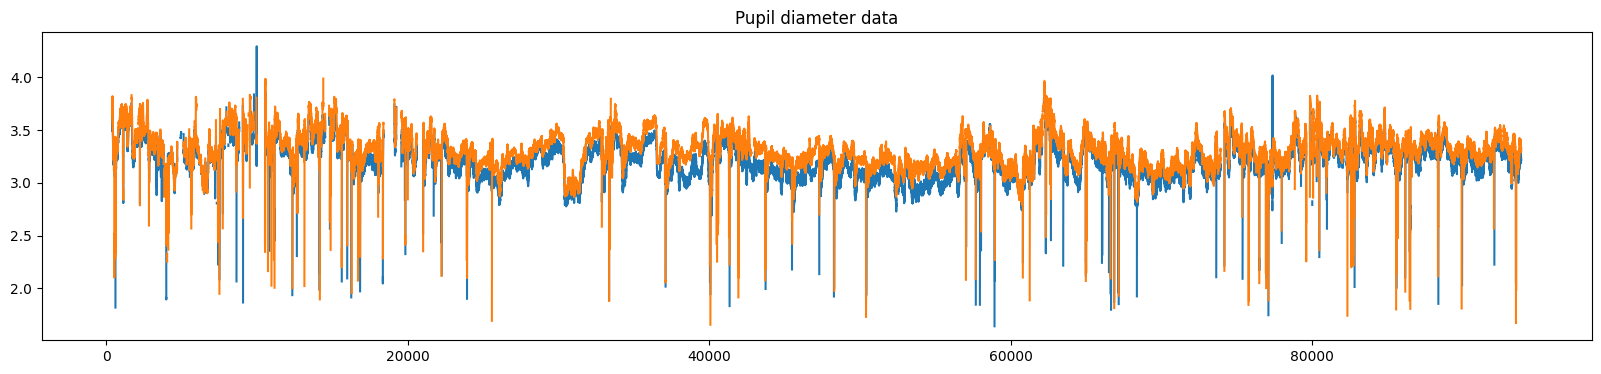

In [18]:
# Plot left_pupil_diameter and right_pupil_diameter
plt.figure(figsize=(20, 4))
plt.plot(et_df['left_pupil_diameter'][:1300000], label='left_pupil_diameter');
plt.plot(et_df['right_pupil_diameter'][:1300000], label='right_pupil_diameter');
plt.title('Pupil diameter data');

<Axes: >

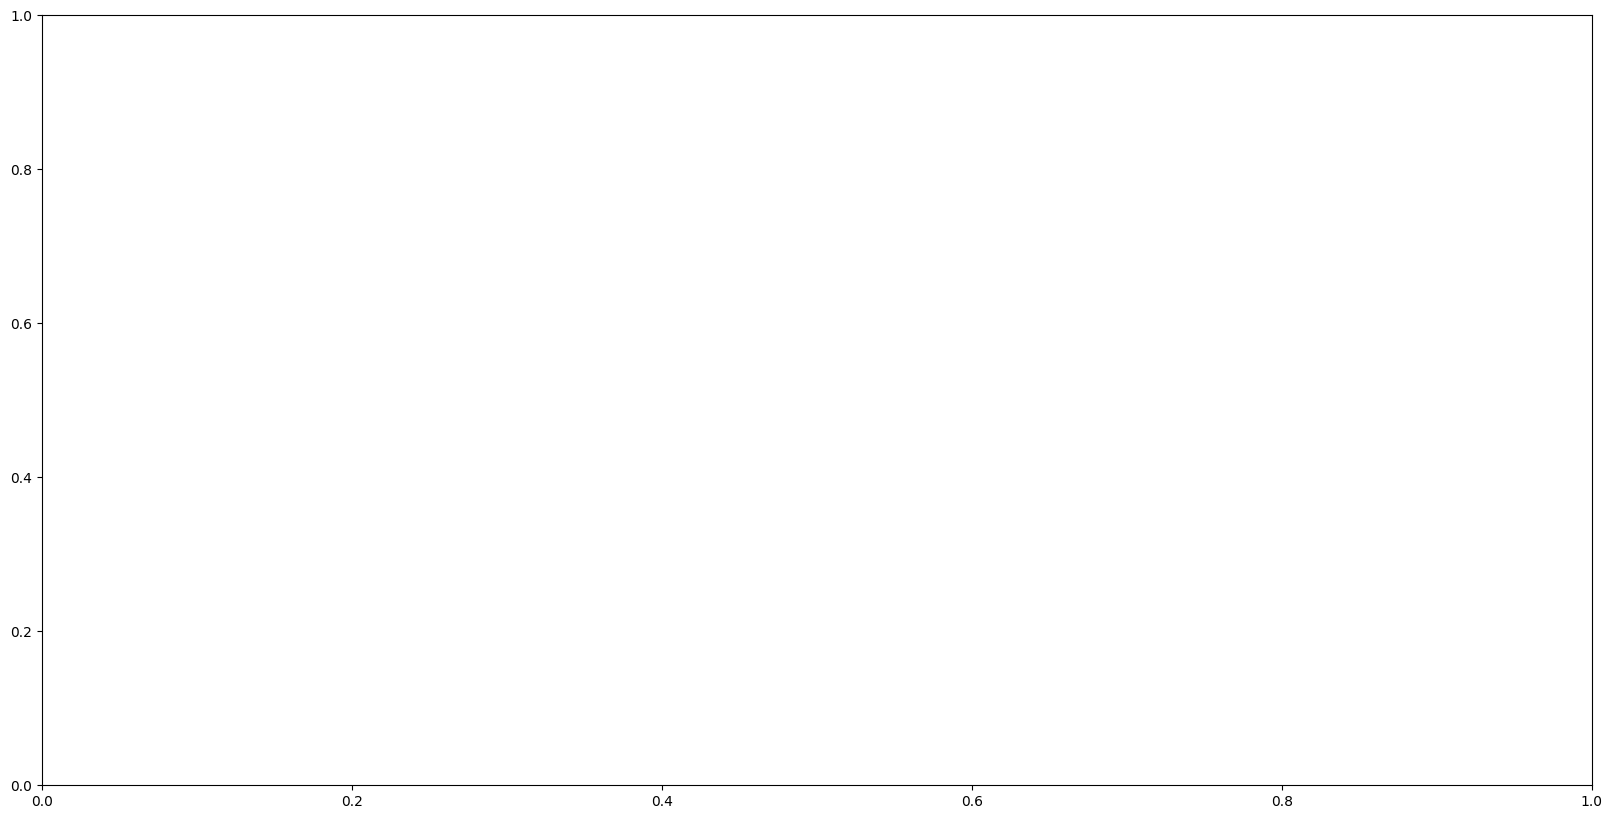

In [31]:

evnt_of_interest = 'CampFriend'
onset = stim_df.loc[stim_df.event == 'Onset_'+ evnt_of_interest, 'time'].values[0]
offset = stim_df.loc[stim_df.event == 'Offset_'+ evnt_of_interest, 'time'].values[0]
left_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_0']
left_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'left_gaze_point_on_display_area_1']
left = pd.DataFrame({'x': left_x, 'y': left_y})
# Right
right_x = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_0']
right_y = et_df.loc[(et_df.time > onset) & (et_df.time < offset), 'right_gaze_point_on_display_area_1']
right = pd.DataFrame({'x': right_x, 'y': right_y})
fig, ax = plt.subplots( figsize=(20, 10))
sns.scatterplot(data=right, x='x', y='y', color='r')
#ax[0].set_title('Right eye')
sns.scatterplot(data=left, x='x', y='y', color='b')
#ax[1].set_title('Left eye')

In [23]:
# Get the units associated with each eyetracking variable
ET['info']['desc'][0]#['channels'][0]['channel'][0]['unit'][0]

defaultdict(list,
            {'manufacturer': ['Tobii'],
             'channels': [defaultdict(list,
                          {'channel': [defaultdict(list,
                                        {'label': ['device_time_stamp'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['left_gaze_origin_validity'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['right_gaze_origin_validity'],
                                         'unit': ['device'],
                                         'type': ['ET']}),
                            defaultdict(list,
                                        {'label': ['left_gaze_origin_in_user_coordinate_system_0'],
       